In [1]:
import math
from scripts_stock.cfg.out_file_name import OutFileName
from scripts_stock.cfg.set_dir import ProjectDir
from scripts_stock.cfg.stock_list import *
from scripts_stock.utils.analysis.stock_stat_index import df_to_stock_df, stock_kdj
import os
from scripts_stock.utils.common import CommonScript
from scripts_stock.utils.string_process import StringProcess
from scripts_stock.data_base.insert_into_db import insert_df_to_db,df_save_to_db
from scripts_stock.data_base.get_table_info import GetDataFromDB
from scripts_stock.data_base.db_py_sql import get_all_fuquan_one_stock
from scripts_stock.utils.logging_set import *

============ import stock list:  stock_list   ================


In [2]:
ss = GetDataFromDB.get_fuquan_stock_index_all()


In [3]:
stock_index = "600795"
df1 = GetDataFromDB.get_fuquan_all_one_stock_df(stock_index)
df2 = df1[df1["date"]>='2018-01-01']
# df2["close"].values

df_weekly= df2.groupby(lambda x:math.floor(x/5)).last()

In [4]:
df1

,date,open,close,high,low,transaction_volume,stock_index,update_time
0,2012-04-13,1.34,1.34,1.36,1.33,97997642.0,600795,2024-11-23 01:03:19.104805
1,2012-04-16,1.33,1.33,1.34,1.31,58613031.0,600795,2024-11-23 01:03:19.104805
2,2012-04-17,1.33,1.30,1.33,1.29,64822093.0,600795,2024-11-23 01:03:19.104805
3,2012-04-18,1.31,1.34,1.36,1.30,132548367.0,600795,2024-11-23 01:03:19.104805
4,2012-04-20,1.33,1.36,1.36,1.32,173658831.0,600795,2024-11-23 01:03:19.104805
...,...,...,...,...,...,...,...,...
2995,2024-11-18,4.76,4.82,4.87,4.76,782534690.0,600795,2024-11-23 01:03:19.104805
2996,2024-11-19,4.81,4.77,4.82,4.73,668841306.0,600795,2024-11-23 01:03:19.104805
2997,2024-11-20,4.76,4.79,4.80,4.74,405034273.0,600795,2024-11-23 01:03:19.104805
2998,2024-11-21,4.77,4.81,4.84,4.77,434235749.0,600795,2024-11-23 01:03:19.104805


In [5]:
import numpy as np
def findpeaks(series, DELTA):
    """
    Finds extrema in a pandas series data.

    Parameters
    ----------
    series : `pandas.Series`
        The data series from which we need to find extrema.

    DELTA : `float`
        The minimum difference between data values that defines a peak.

    Returns
    -------
    minpeaks, maxpeaks : `list`
        Lists consisting of pos, val pairs for both local minima points and
        local maxima points.
    """
    # Set initial values
    mn, mx = np.inf, -np.inf
    minpeaks = []
    maxpeaks = []
    lookformax = True
    start = True
    # Iterate over items in series
    for time_pos, value in series.items():
        if value > mx:
            mx = value
            mxpos = time_pos
        if value < mn:
            mn = value
            mnpos = time_pos
        if lookformax:
            if value < mx-DELTA:
                # a local maxima
                maxpeaks.append((mxpos, mx))
                mn = value
                mnpos = time_pos
                lookformax = False
            elif start:
                # a local minima at beginning
                minpeaks.append((mnpos, mn))
                mx = value
                mxpos = time_pos
                start = False
        else:
            if value > mn+DELTA:
                # a local minima
                minpeaks.append((mnpos, mn))
                mx = value
                mxpos = time_pos
                lookformax = True
    # check for extrema at end
    if value > mn+DELTA:
        maxpeaks.append((mxpos, mx))
    elif value < mx-DELTA:
        minpeaks.append((mnpos, mn))
    return minpeaks, maxpeaks

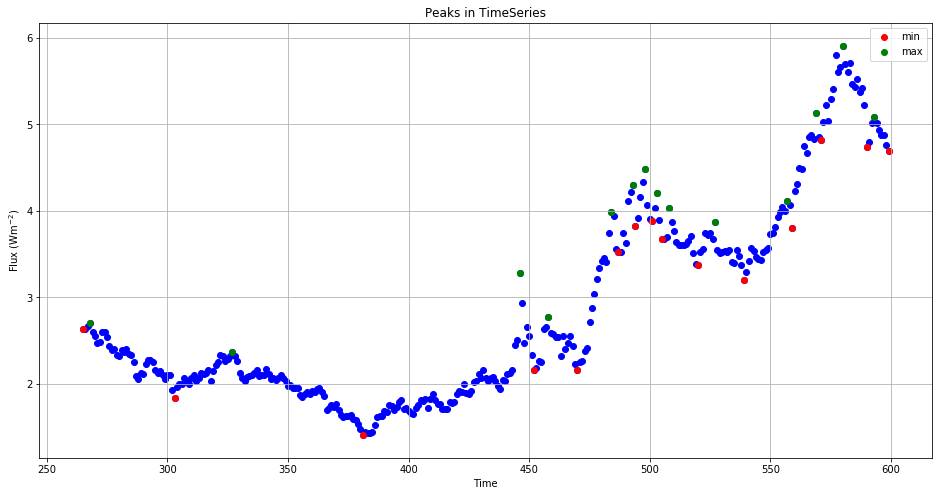

In [7]:
import matplotlib.pyplot as plt
#delta_in = np.mean(df2['close'])/15
delta_in = np.mean(df_weekly['close'])/10

series = df_weekly['close']
minpeaks, maxpeaks = findpeaks(series, DELTA=delta_in)

# Plotting the figure and extremum points

fig, ax = plt.subplots(figsize=(16, 8))

ax.set_xlabel('Time')
ax.set_ylabel("Flux (Wm$^{-2}$)")
ax.set_title('Peaks in TimeSeries')
#series.plot(ax=ax)
series_list = series.reset_index().values.tolist()
ax.scatter(*zip(*series_list), color='blue')
ax.scatter(*zip(*minpeaks), color='red', label='min')
ax.scatter(*zip(*maxpeaks), color='green', label='max')

ax.legend()
ax.grid(True)

plt.show()

In [ ]:
df_weekly

,close,date,high,low,open,stock_index,transaction_volume,update_time
266,4.24,2018-01-03,4.40,4.20,4.26,601398,2.172614e+09,2024-11-17 21:41:31.906799
267,4.24,2018-01-10,4.27,4.14,4.16,601398,1.528503e+09,2024-11-17 21:41:31.906799
268,4.80,2018-01-17,5.07,4.72,4.72,601398,3.985715e+09,2024-11-17 21:41:31.906799
269,5.48,2018-01-24,5.74,5.38,5.57,601398,3.730796e+09,2024-11-17 21:41:31.906799
270,5.56,2018-01-31,5.58,5.29,5.36,601398,2.761036e+09,2024-11-17 21:41:31.906799
...,...,...,...,...,...,...,...,...
595,6.32,2024-10-18,6.36,6.21,6.29,601398,3.236240e+09,2024-11-17 21:41:31.906799
596,6.12,2024-10-25,6.17,6.10,6.15,601398,1.742297e+09,2024-11-17 21:41:31.906799
597,6.15,2024-11-01,6.15,6.03,6.04,601398,2.760340e+09,2024-11-17 21:41:31.906799
598,6.11,2024-11-08,6.17,6.10,6.15,601398,2.021390e+09,2024-11-17 21:41:31.906799


In [ ]:
max_index = [x[0] for x in maxpeaks]
min_index = [x[0] for x in minpeaks]

df_weekly["local_peak"] = 0
df_weekly.loc[max_index,"local_peak"]=1
df_weekly.loc[min_index,"local_peak"]=-1

In [ ]:
df_weekly

,close,date,high,low,open,stock_index,transaction_volume,update_time,local_peak
266,4.24,2018-01-03,4.40,4.20,4.26,601398,2.172614e+09,2024-11-17 21:41:31.906799,-1
267,4.24,2018-01-10,4.27,4.14,4.16,601398,1.528503e+09,2024-11-17 21:41:31.906799,0
268,4.80,2018-01-17,5.07,4.72,4.72,601398,3.985715e+09,2024-11-17 21:41:31.906799,0
269,5.48,2018-01-24,5.74,5.38,5.57,601398,3.730796e+09,2024-11-17 21:41:31.906799,0
270,5.56,2018-01-31,5.58,5.29,5.36,601398,2.761036e+09,2024-11-17 21:41:31.906799,1
...,...,...,...,...,...,...,...,...,...
595,6.32,2024-10-18,6.36,6.21,6.29,601398,3.236240e+09,2024-11-17 21:41:31.906799,0
596,6.12,2024-10-25,6.17,6.10,6.15,601398,1.742297e+09,2024-11-17 21:41:31.906799,0
597,6.15,2024-11-01,6.15,6.03,6.04,601398,2.760340e+09,2024-11-17 21:41:31.906799,0
598,6.11,2024-11-08,6.17,6.10,6.15,601398,2.021390e+09,2024-11-17 21:41:31.906799,0


In [ ]:
df_max = pd.DataFrame(maxpeaks)

,0,1
0,270,5.56
1,355,4.49
2,421,4.43
3,589,6.49


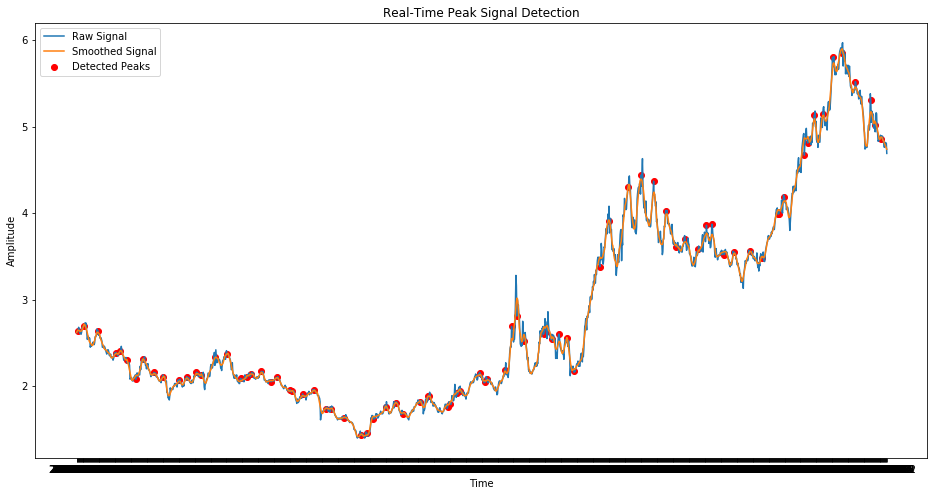

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

np.random.seed(0)
# time = np.linspace(0, 10, 1000)
time = df2["date"].values
# signal = np.sin(time) + np.random.normal(0, 0.1, size=len(time))

signal = df2["close"].values
smoothed_signal = savgol_filter(signal, window_length=15, polyorder=3)

# Find peaks using derivative-based method
derivative = np.gradient(smoothed_signal)
peaks = np.where((derivative[:-1] > 0) & (derivative[1:] < 0))[0]

# Plot signal and detected peaks
plt.figure(figsize=(16, 8))  # 单位为英寸

plt.plot(time, signal, label='Raw Signal')
plt.plot(time, smoothed_signal, label='Smoothed Signal')
plt.scatter(time[peaks], signal[peaks], c='r', marker='o', label='Detected Peaks')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Real-Time Peak Signal Detection')
plt.show()